In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Data source – [https://www.kaggle.com/datasets/shivamb/netflix-shows](https://www.kaggle.com/datasets/shivamb/netflix-shows)

In [ ]:
df = pd.read_csv('netflix_titles.csv')

---

### **Data preprocessing**

**show_id** – unique identifier of the show/movie

**type** – content type (Movie / TV Show)

**title** – title

**director** – director

**cast** – cast

**country** – country of production

**date_added** – date added to the platform

**release_year** – year of release

**rating** – age rating

**duration** – duration (in minutes or seasons)

**listed_in** – genres/categories

**description** – plot description

We are preprocessing the **rating** because duration accidentally got into it.

In [3]:
# Example
df.query('rating == "66 min"')[['rating', 'duration']]

,rating,duration
5813,66 min,NaN


In [4]:
mask = (df['rating'].str.contains('min', na=False)) & (df['duration'].isna())

df.loc[mask, 'duration'] = df.loc[mask, 'rating']
df.loc[mask, 'rating'] = None

In [5]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [6]:
df.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

**Content type**

In [7]:
content_types_df = pd.DataFrame({
    'id': [1, 2],
    'name': ['Movie', 'TV Show']
})

**Main**

In [8]:
shows_df = df[['show_id', 'title', 'date_added', 'release_year', 'rating', 'duration', 'description']].copy()

shows_df['type_id'] = df['type'].map({'Movie': 1, 'TV Show': 2})

shows_df['date_added'] = pd.to_datetime(shows_df['date_added'], errors='coerce', format='mixed')

In [9]:
shows_df.head()

,show_id,title,date_added,release_year,rating,duration,description,type_id
0,s1,Dick Johnson Is Dead,2021-09-25,2020,PG-13,90 min,"As her father nears the end of his life, filmm...",1
1,s2,Blood & Water,2021-09-24,2021,TV-MA,2 Seasons,"After crossing paths at a party, a Cape Town t...",2
2,s3,Ganglands,2021-09-24,2021,TV-MA,1 Season,To protect his family from a powerful drug lor...,2
3,s4,Jailbirds New Orleans,2021-09-24,2021,TV-MA,1 Season,"Feuds, flirtations and toilet talk go down amo...",2
4,s5,Kota Factory,2021-09-24,2021,TV-MA,2 Seasons,In a city of coaching centers known to train I...,2


**Directors**

In [10]:
all_directors = []

for directors_str in df['director'].dropna():
    directors = [d.strip() for d in directors_str.split(',')]
    all_directors.extend(directors)

directors_df = pd.DataFrame({'name': list(set(all_directors))})
directors_df = directors_df.sort_values('name').reset_index(drop=True)

directors_df = directors_df.reset_index().rename(columns={'index': 'id'})

directors_df['id'] = directors_df['id'] + 1

In [11]:
directors_df.head()

,id,name
0,1,A. L. Vijay
1,2,A. Raajdheep
2,3,A. Salaam
3,4,A.R. Murugadoss
4,5,Aadish Keluskar


**movie_directors** – association (many-to-many relationship)

In [12]:
show_directors_data = []

for idx, row in df[['show_id', 'director']].dropna(subset=['director']).iterrows():
    show_id = row['show_id']
    directors_str = row['director']

    directors = [d.strip().replace('"', '').replace("'", "") for d in directors_str.split(',')]

    for director_name in directors:
        show_directors_data.append({
            'show_id': show_id,
            'director': director_name
        })

show_directors_df = pd.DataFrame(show_directors_data)

show_directors_df = show_directors_df.merge(
    directors_df[['id', 'name']],
    left_on='director',
    right_on='name'
)

show_directors_df = show_directors_df.rename(columns={'id': 'director_id'})
show_directors_df = show_directors_df[['show_id', 'director_id']]

In [13]:
show_directors_df.head()

,show_id,director_id
0,s1,2533
1,s3,2323
2,s6,3163
3,s7,3917
4,s7,2290


**Actors**

In [14]:
all_actors = []

for cast_str in df['cast'].dropna():
    actors = [a.strip().replace('"', '').replace("'", "") for a in cast_str.split(',')]
    all_actors.extend(actors)

actors_df = pd.DataFrame({'name': list(set(all_actors))})
actors_df = actors_df.sort_values('name').reset_index(drop=True)

actors_df = actors_df.reset_index().rename(columns={'index': 'id'})

actors_df['id'] = actors_df['id'] + 1

In [15]:
actors_df.head()

,id,name
0,1,2 Chainz
1,2,2Mex
2,3,4Minute
3,4,50 Cent
4,5,9m88


**movie_actors** – association (many-to-many relationship)

In [16]:
show_actors_data = []

for idx, row in df[['show_id', 'cast']].dropna(subset=['cast']).iterrows():
    show_id = row['show_id']
    cast_str = row['cast']

    actors = [a.strip().replace('"', '').replace("'", "") for a in cast_str.split(',')]

    for actor_name in actors:
        show_actors_data.append({
            'show_id': show_id,
            'actor': actor_name
        })

show_actors_df = pd.DataFrame(show_actors_data)

show_actors_df = show_actors_df.merge(
    actors_df[['id', 'name']],
    left_on='actor',
    right_on='name'
)

show_actors_df = show_actors_df.rename(columns={'id': 'actor_id'})
show_actors_df = show_actors_df[['show_id', 'actor_id']]

In [17]:
show_actors_df.head()

,show_id,actor_id
0,s2,1602
1,s2,18113
2,s2,11093
3,s2,33079
4,s2,8649


**Genres**

In [18]:
all_genres = []

for genre_str in df['listed_in'].dropna():
    genres = [g.strip().replace('"', '').replace("'", "") for g in genre_str.split(',')]
    all_genres.extend(genres)

genres_df = pd.DataFrame({'name': list(set(all_genres))})
genres_df = genres_df.sort_values('name').reset_index(drop=True)

genres_df = genres_df.reset_index().rename(columns={'index': 'id'})

genres_df['id'] = genres_df['id'] + 1

In [19]:
genres_df.head()

,id,name
0,1,Action & Adventure
1,2,Anime Features
2,3,Anime Series
3,4,British TV Shows
4,5,Children & Family Movies


**movie_genres** - association (many-to-many relationship)

In [20]:
show_genres_data = []

for idx, row in df[['show_id', 'listed_in']].dropna(subset=['listed_in']).iterrows():
    show_id = row['show_id']
    genres_str = row['listed_in']

    genres = [g.strip().replace('"', '').replace("'", "") for g in genres_str.split(',')]

    for genre_name in genres:
        show_genres_data.append({
            'show_id': show_id,
            'genre': genre_name
        })

show_genres_df = pd.DataFrame(show_genres_data)

show_genres_df = show_genres_df.merge(
    genres_df[['id', 'name']],
    left_on='genre',
    right_on='name'
)

show_genres_df = show_genres_df.rename(columns={'id': 'genre_id'})
show_genres_df = show_genres_df[['show_id', 'genre_id']]

In [21]:
show_genres_df.head()

,show_id,genre_id
0,s1,11
1,s2,18
2,s2,35
3,s2,37
4,s3,9


**Countries**

In [22]:
all_countries = []

for country_str in df['country'].dropna():
    countries = [c.strip() for c in country_str.split(',') if c.strip() != '']
    all_countries.extend(countries)

countries_df = pd.DataFrame({'name': sorted(set(all_countries))}).reset_index()
countries_df = countries_df.rename(columns={'index': 'id'})
countries_df['id'] = countries_df['id'] + 1

In [23]:
countries_df.head()

,id,name
0,1,Afghanistan
1,2,Albania
2,3,Algeria
3,4,Angola
4,5,Argentina


**show_countries** - association (many-to-many relationship)

In [24]:
show_countries_data = []

for idx, row in df[['show_id', 'country']].dropna(subset=['country']).iterrows():
    show_id = row['show_id']
    countries_str = row['country']

    countries = [c.strip() for c in countries_str.split(',')]

    for country_name in countries:
        show_countries_data.append({
            'show_id': show_id,
            'country': country_name
        })

show_countries_df = pd.DataFrame(show_countries_data)
show_countries_df = show_countries_df.merge(
    countries_df[['id', 'name']],
    left_on='country',
    right_on='name'
)
show_countries_df = show_countries_df.rename(columns={'id': 'country_id'})
show_countries_df = show_countries_df[['show_id', 'country_id']]

We have different durations: for shows, it’s in seasons, and for movies, it’s in minutes.

In [25]:
shows_df = df[['show_id', 'title', 'date_added', 'release_year', 'rating', 'description']].copy()
shows_df['type_id'] = df['type'].map({'Movie': 1, 'TV Show': 2})

shows_df['duration_minutes'] = None
shows_df['seasons_count'] = None

is_movie = df['type'] == 'Movie'
is_tv = df['type'] == 'TV Show'

shows_df.loc[is_movie, 'duration_minutes'] = (
    df.loc[is_movie, 'duration']
    .str.replace(' min', '')
    .astype(float)
)

shows_df.loc[is_tv, 'seasons_count'] = (
    df.loc[is_tv, 'duration']
    .str.replace(' Season', '')
    .str.replace('s', '')
    .astype(float)
)

shows_df['date_added'] = pd.to_datetime(shows_df['date_added'], errors='coerce')

In [26]:
shows_df.head()

,show_id,title,date_added,release_year,rating,description,type_id,duration_minutes,seasons_count
0,s1,Dick Johnson Is Dead,2021-09-25,2020,PG-13,"As her father nears the end of his life, filmm...",1,90.0,None
1,s2,Blood & Water,2021-09-24,2021,TV-MA,"After crossing paths at a party, a Cape Town t...",2,None,2.0
2,s3,Ganglands,2021-09-24,2021,TV-MA,To protect his family from a powerful drug lor...,2,None,1.0
3,s4,Jailbirds New Orleans,2021-09-24,2021,TV-MA,"Feuds, flirtations and toilet talk go down amo...",2,None,1.0
4,s5,Kota Factory,2021-09-24,2021,TV-MA,In a city of coaching centers known to train I...,2,None,2.0


It turns out that duplicates somehow got in.

In [27]:
show_actors_df_clean = show_actors_df.drop_duplicates(subset=['show_id', 'actor_id'])
show_actors_df = show_actors_df_clean

In [28]:
show_directors_df_clean = show_directors_df.drop_duplicates(subset=['show_id', 'director_id'])
show_directors_df = show_directors_df_clean

---

### Connecting to DuckDB

In [29]:
import duckdb

con = duckdb.connect("netflix_final.duckdb")

In [30]:
# Creating tables
con.execute('''
CREATE TABLE IF NOT EXISTS content_types (
    id INTEGER PRIMARY KEY,
    name VARCHAR NOT NULL UNIQUE
)
''')

con.execute('''
CREATE TABLE IF NOT EXISTS countries (
    id INTEGER PRIMARY KEY,
    name VARCHAR NOT NULL UNIQUE
)
''')

con.execute('''
CREATE TABLE IF NOT EXISTS directors (
    id INTEGER PRIMARY KEY,
    name VARCHAR NOT NULL UNIQUE
)
''')

con.execute('''
CREATE TABLE IF NOT EXISTS actors (
    id INTEGER PRIMARY KEY,
    name VARCHAR NOT NULL UNIQUE
)
''')

con.execute('''
CREATE TABLE IF NOT EXISTS genres (
    id INTEGER PRIMARY KEY,
    name VARCHAR NOT NULL UNIQUE
)
''')

con.execute('''
CREATE TABLE IF NOT EXISTS shows (
    show_id VARCHAR PRIMARY KEY,
    title VARCHAR NOT NULL,
    type_id INTEGER,
    date_added DATE,
    release_year INTEGER,
    rating VARCHAR,
    duration_minutes INTEGER,
    seasons_count INTEGER,
    description VARCHAR,
    FOREIGN KEY (type_id) REFERENCES content_types(id)
)
''')

con.execute('''
CREATE TABLE IF NOT EXISTS show_directors (
    show_id VARCHAR,
    director_id INTEGER,
    FOREIGN KEY (show_id) REFERENCES shows(show_id),
    FOREIGN KEY (director_id) REFERENCES directors(id)
)
''')

con.execute('''
CREATE TABLE IF NOT EXISTS show_actors (
    show_id VARCHAR,
    actor_id INTEGER,
    FOREIGN KEY (show_id) REFERENCES shows(show_id),
    FOREIGN KEY (actor_id) REFERENCES actors(id)
)
''')

con.execute('''
CREATE TABLE IF NOT EXISTS show_genres (
    show_id VARCHAR,
    genre_id INTEGER,
    PRIMARY KEY (show_id, genre_id),
    FOREIGN KEY (show_id) REFERENCES shows(show_id),
    FOREIGN KEY (genre_id) REFERENCES genres(id)
)
''')

con.execute('''
CREATE TABLE IF NOT EXISTS show_countries (
    show_id VARCHAR,
    country_id INTEGER,
    PRIMARY KEY (show_id, country_id),
    FOREIGN KEY (show_id) REFERENCES shows(show_id),
    FOREIGN KEY (country_id) REFERENCES countries(id)
)
''')

In [31]:
# Registering all tables
con.register('content_types_df', content_types_df)
con.register('countries_df', countries_df)
con.register('directors_df', directors_df)
con.register('actors_df', actors_df)
con.register('genres_df', genres_df)
con.register('shows_df', shows_df)
con.register('show_directors_df', show_directors_df)
con.register('show_actors_df', show_actors_df)
con.register('show_genres_df', show_genres_df)
con.register('show_countries_df', show_countries_df)

# Cleaning data in the correct order (needed if recreating the database)
con.execute('DELETE FROM show_directors')
con.execute('DELETE FROM show_actors')
con.execute('DELETE FROM show_genres')
con.execute('DELETE FROM show_countries')
con.execute('DELETE FROM shows')
con.execute('DELETE FROM content_types')
con.execute('DELETE FROM countries')
con.execute('DELETE FROM directors')
con.execute('DELETE FROM actors')
con.execute('DELETE FROM genres')

# Inserting data in the correct order (starting with the base tables)
# For the show table, there was an issue with the data type of the column date_added, so we explicitly define its type
con.execute('INSERT INTO content_types SELECT * FROM content_types_df')
con.execute('INSERT INTO countries SELECT * FROM countries_df')
con.execute('INSERT INTO directors SELECT * FROM directors_df')
con.execute('INSERT INTO actors SELECT * FROM actors_df')
con.execute('INSERT INTO genres SELECT * FROM genres_df')
con.execute('INSERT INTO shows SELECT show_id, title, type_id, CAST(date_added AS DATE), release_year, rating, duration_minutes, seasons_count, description FROM shows_df')
con.execute('INSERT INTO show_directors SELECT * FROM show_directors_df')
con.execute('INSERT INTO show_actors SELECT * FROM show_actors_df')
con.execute('INSERT INTO show_genres SELECT * FROM show_genres_df')
con.execute('INSERT INTO show_countries SELECT * FROM show_countries_df')

# Unregistering after insertion
con.unregister('content_types_df')
con.unregister('countries_df')
con.unregister('directors_df')
con.unregister('actors_df')
con.unregister('genres_df')
con.unregister('shows_df')
con.unregister('show_directors_df')
con.unregister('show_actors_df')
con.unregister('show_genres_df')
con.unregister('show_countries_df')

In [32]:
con.close()

---

### SQL queries

As part of this work, we created a tool that allows us to explore the structure of the Netflix content database, the distribution of genres and production countries, activity by release year, and the frequency of collaborations with specific directors and actors.

We aim to answer the following questions:

1. Which directors are the most productive in the Netflix database?
2. How are shows distributed in the database by age rating, and how has this distribution changed over the years?
3. Which pairs of actors have worked together most frequently?
4. In which countries are shows most often produced? Does the USA remain the leader, or has India managed to catch up?
5. How are shows distributed by genre?

**Top 10 directors by number of shows**

In [33]:
con = duckdb.connect('netflix_final.duckdb')

query = """
SELECT d.name AS director, COUNT(sd.show_id) AS show_count
FROM directors d
JOIN show_directors sd ON d.id = sd.director_id
GROUP BY d.name
ORDER BY show_count DESC
LIMIT 10;
"""

result = con.sql(query).df()
result

,director,show_count
0,Rajiv Chilaka,22
1,Jan Suter,21
2,Raúl Campos,19
3,Marcus Raboy,16
4,Suhas Kadav,16
5,Jay Karas,15
6,Cathy Garcia-Molina,13
7,Martin Scorsese,12
8,Youssef Chahine,12
9,Jay Chapman,12


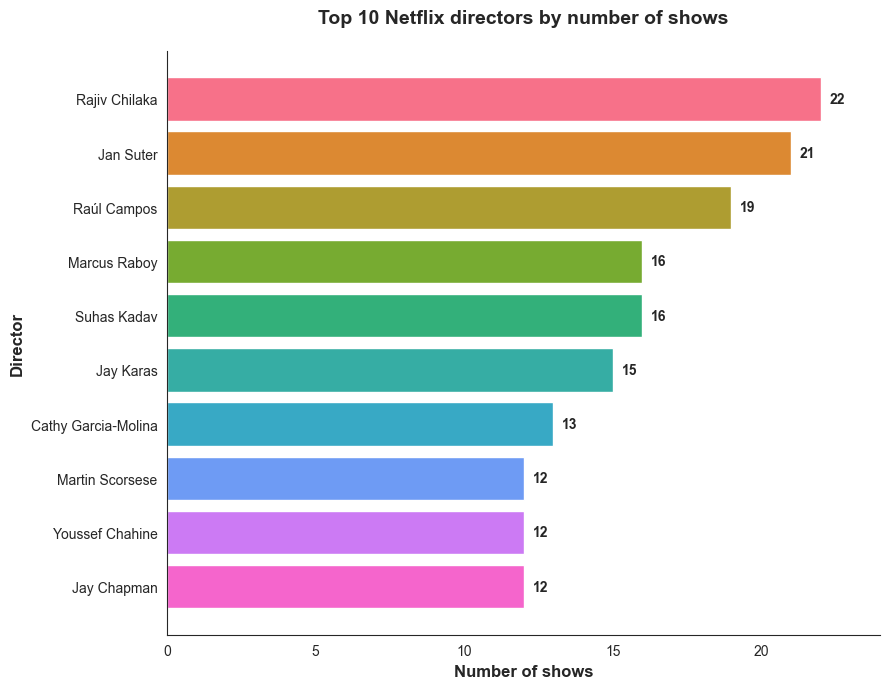

In [34]:
sns.set_style("white")
plt.figure(figsize=(9, 7))
colors = sns.color_palette("husl", len(result))
bars = plt.barh(result['director'], result['show_count'], color=colors)

for i, (bar, value) in enumerate(zip(bars, result['show_count'])):
    plt.text(value + 0.3, i, f'{value}', 
             va='center', fontsize=10, fontweight='bold')

plt.xlabel('Number of shows', fontsize=12, fontweight='bold')
plt.ylabel('Director', fontsize=12, fontweight='bold')
plt.title('Top 10 Netflix directors by number of shows', fontsize=14, fontweight='bold', pad=20)
plt.xlim(0, max(result['show_count']) + 2)
plt.gca().invert_yaxis()
sns.despine()
plt.tight_layout()
plt.show()

In [35]:
con.close()

---

**Distribution of shows by age rating**

In [36]:
con = duckdb.connect('netflix_final.duckdb')

query = """
SELECT 
    rating,
    COUNT(*) AS total
FROM shows
GROUP BY rating
ORDER BY total DESC;
"""

result = con.sql(query).df()
result

,rating,total
0,TV-MA,3207
1,TV-14,2160
2,TV-PG,863
3,R,799
4,PG-13,490
5,TV-Y7,334
6,TV-Y,307
7,PG,287
8,TV-G,220
9,NR,80


In [37]:
con.close()

**Dynamics of age ratings over the years**

In [38]:
con = duckdb.connect('netflix_final.duckdb')

query = """
WITH top_ratings AS (
    SELECT rating
    FROM shows
    GROUP BY rating
    ORDER BY COUNT(*) DESC
    LIMIT 8
)
SELECT 
    release_year,
    s.rating,
    COUNT(*) AS total
FROM shows s
INNER JOIN top_ratings tr ON s.rating = tr.rating
GROUP BY release_year, s.rating
ORDER BY release_year, total DESC;
"""

result = con.sql(query).df()

result_pivot = result.pivot(index='release_year', columns='rating', values='total').fillna(0)
result_pivot

rating,PG,PG-13,R,TV-14,TV-MA,TV-PG,TV-Y,TV-Y7
release_year,,,,,,,,
1925,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1942,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
1944,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0
1945,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2017,15.0,32.0,73.0,251.0,451.0,111.0,31.0,37.0
2018,31.0,30.0,52.0,268.0,549.0,105.0,41.0,40.0
2019,12.0,19.0,39.0,252.0,500.0,98.0,50.0,36.0


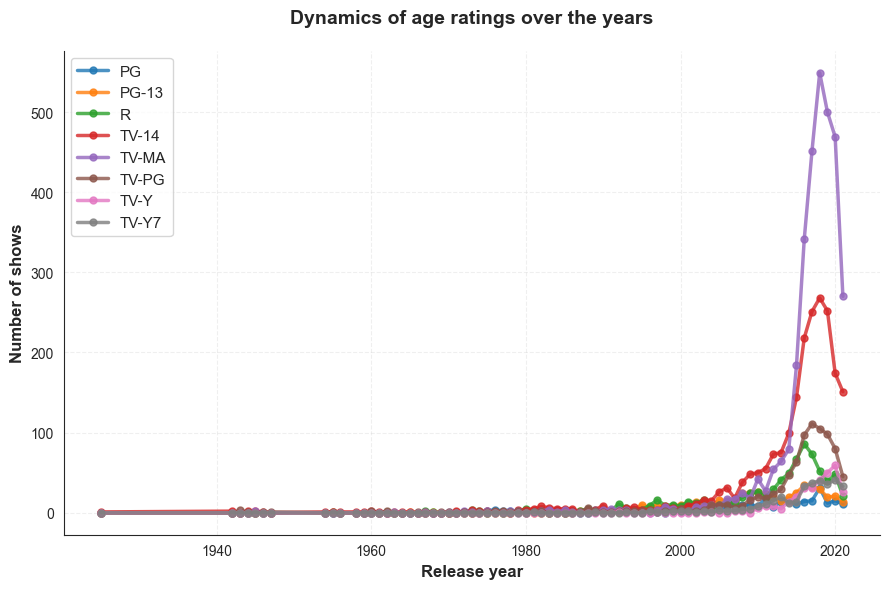

In [39]:
sns.set_style("white")
plt.figure(figsize=(9, 6))

ratings = result_pivot.columns
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

for i, rating in enumerate(ratings):
    plt.plot(result_pivot.index, result_pivot[rating], 
             color=colors[i % len(colors)], linewidth=2.5, marker='o', markersize=5,
             label=rating, alpha=0.8)

plt.xlabel('Release year', fontsize=12, fontweight='bold')
plt.ylabel('Number of shows', fontsize=12, fontweight='bold')
plt.title('Dynamics of age ratings over the years', 
          fontsize=14, fontweight='bold', pad=20)
plt.legend(fontsize=11, loc='upper left')
plt.grid(True, alpha=0.3, linestyle='--')
sns.despine()
plt.tight_layout()

plt.show()

In [40]:
con.close()

---

**Top 10 most frequent pairs of actors who appeared together**

In [41]:
con = duckdb.connect('netflix_final.duckdb')

query = """
WITH actor_pairs AS (
    SELECT sa1.actor_id as actor1_id, sa2.actor_id as actor2_id, sa1.show_id
    FROM show_actors sa1
    JOIN show_actors sa2 ON sa1.show_id = sa2.show_id
    WHERE sa1.actor_id < sa2.actor_id
),
pair_counts AS (
    SELECT actor1_id, actor2_id, COUNT(*) as times_together
    FROM actor_pairs ap
    GROUP BY actor1_id, actor2_id
    HAVING COUNT(*) >= 2
)
SELECT a1.name as actor1, a2.name as actor2, pc.times_together
FROM pair_counts pc
JOIN actors a1 ON pc.actor1_id = a1.id
JOIN actors a2 ON pc.actor2_id = a2.id
ORDER BY pc.times_together DESC
LIMIT 10;
"""

result = con.sql(query).df()
result

,actor1,actor2,times_together
0,Julie Tejwani,Rupa Bhimani,31
1,Julie Tejwani,Rajesh Kava,24
2,Rajesh Kava,Rupa Bhimani,22
3,Jigna Bhardwaj,Julie Tejwani,21
4,Jigna Bhardwaj,Rupa Bhimani,20
5,Jigna Bhardwaj,Rajesh Kava,20
6,Julie Tejwani,Vatsal Dubey,18
7,Jigna Bhardwaj,Vatsal Dubey,18
8,Rupa Bhimani,Vatsal Dubey,18
9,Rajesh Kava,Vatsal Dubey,17


In [42]:
con.close()

---

**Top 5 countries by number of shows**

In [43]:
con = duckdb.connect('netflix_final.duckdb')

query = """
SELECT c.name AS country, COUNT(sc.show_id) AS show_count
FROM countries c
JOIN show_countries sc ON c.id = sc.country_id
GROUP BY c.name
ORDER BY show_count DESC
LIMIT 5;
"""

result = con.sql(query).df()
result

,country,show_count
0,United States,3690
1,India,1046
2,United Kingdom,806
3,Canada,445
4,France,393


In [44]:
con.close()

**Dynamics of show production in the top 5 most productive countries**

In [45]:
con = duckdb.connect('netflix_final.duckdb')

query = """
WITH top5_countries AS (
    SELECT c.name
    FROM countries c
    JOIN show_countries sc ON c.id = sc.country_id
    GROUP BY c.name
    ORDER BY COUNT(sc.show_id) DESC
    LIMIT 5
)
SELECT 
    s.release_year,
    c.name AS country,
    COUNT(sc.show_id) AS total_shows
FROM shows s
JOIN show_countries sc ON s.show_id = sc.show_id
JOIN countries c ON sc.country_id = c.id
WHERE c.name IN (SELECT name FROM top5_countries)
GROUP BY s.release_year, c.name
ORDER BY s.release_year, c.name;
"""
result = con.sql(query).df()

result

,release_year,country,total_shows
0,1942,United States,2
1,1943,United States,3
2,1944,United Kingdom,1
3,1944,United States,3
4,1945,United States,4
...,...,...,...
232,2021,Canada,12
233,2021,France,13
234,2021,India,35
235,2021,United Kingdom,36


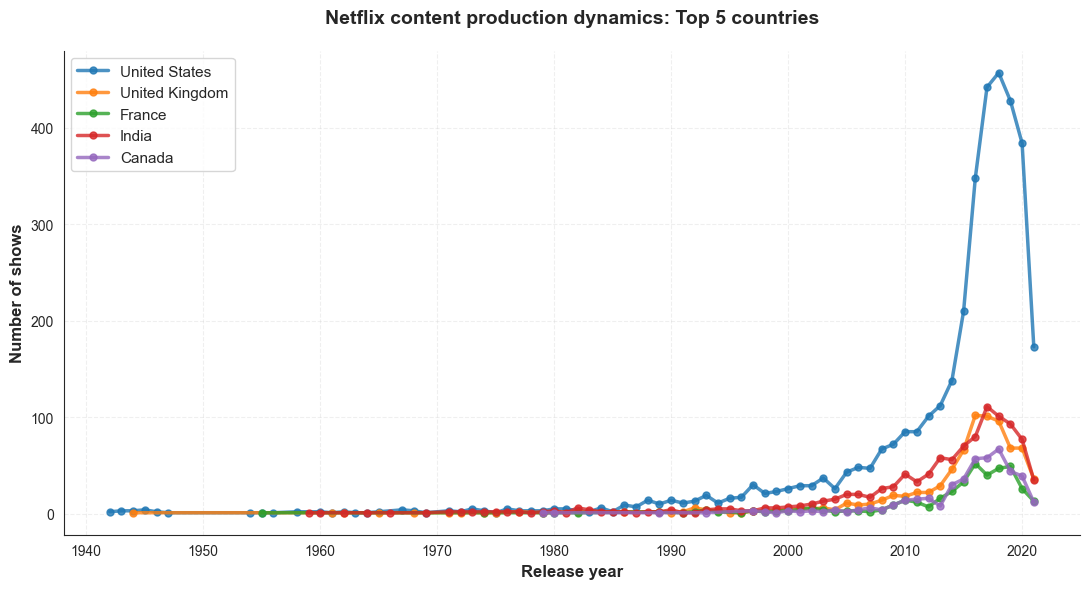

In [46]:
sns.set_style("white")
plt.figure(figsize=(11, 6))

countries = result['country'].unique()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for i, country in enumerate(countries):
    country_data = result[result['country'] == country]
    plt.plot(country_data['release_year'], country_data['total_shows'], 
             color=colors[i], linewidth=2.5, marker='o', markersize=5, 
             label=country, alpha=0.8)

plt.xlabel('Release year', fontsize=12, fontweight='bold')
plt.ylabel('Number of shows', fontsize=12, fontweight='bold')
plt.title('Netflix content production dynamics: Top 5 countries', 
          fontsize=14, fontweight='bold', pad=20)
plt.legend(fontsize=11, loc='upper left')
plt.grid(True, alpha=0.3, linestyle='--')
sns.despine()
plt.tight_layout()

plt.show()

In [47]:
con.close()

---

**Top 6 genres among all genres by percentage share**

In [48]:
con = duckdb.connect('netflix_final.duckdb')

query = """
SELECT 
    g.name AS genre,
    COUNT(sg.show_id) AS total_shows,
    ROUND(
        100.0 * COUNT(sg.show_id) / SUM(COUNT(sg.show_id)) OVER (), 2
    ) AS percent_of_total
FROM genres g
JOIN show_genres sg ON g.id = sg.genre_id
GROUP BY g.name
ORDER BY percent_of_total DESC
LIMIT 6;
"""

result = con.sql(query).df()
result

,genre,total_shows,percent_of_total
0,International Movies,2752,14.24
1,Dramas,2427,12.56
2,Comedies,1674,8.66
3,International TV Shows,1351,6.99
4,Documentaries,869,4.50
5,Action & Adventure,859,4.45


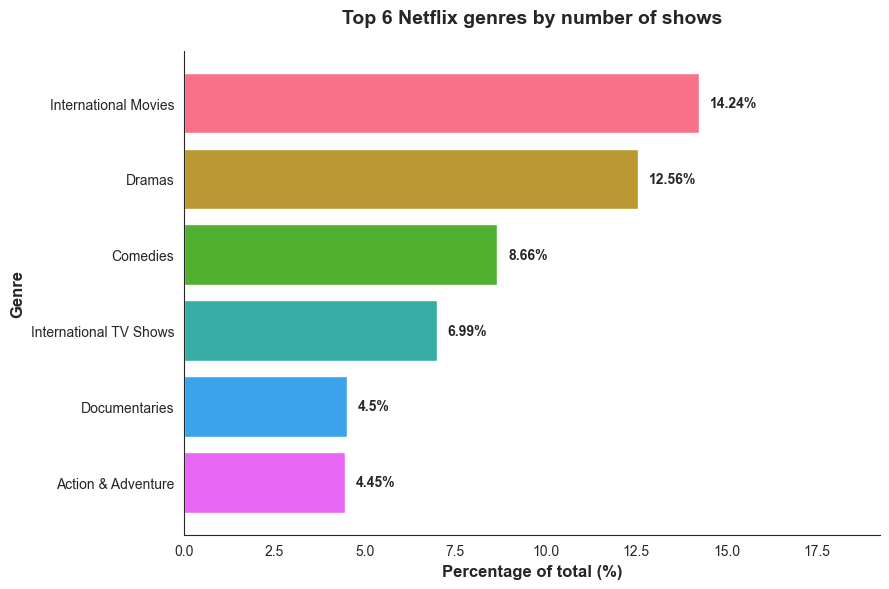

In [49]:
sns.set_style("white")
plt.figure(figsize=(9, 6))

colors = sns.color_palette("husl", len(result))
bars = plt.barh(result['genre'], result['percent_of_total'], color=colors)

for i, (bar, value) in enumerate(zip(bars, result['percent_of_total'])):
    plt.text(value + 0.3, i, f'{value}%', 
             va='center', fontsize=10, fontweight='bold')

plt.xlabel('Percentage of total (%)', fontsize=12, fontweight='bold')
plt.ylabel('Genre', fontsize=12, fontweight='bold')
plt.title('Top 6 Netflix genres by number of shows', fontsize=14, fontweight='bold', pad=20)
plt.xlim(0, max(result['percent_of_total']) + 5)
plt.gca().invert_yaxis()
sns.despine()
plt.tight_layout()

plt.show()

In [50]:
con.close()

---

**Top 3 countries by number of releases in 2000 and 2020**

In [51]:
con = duckdb.connect('netflix_final.duckdb')

query = """
SELECT 
    release_year,
    c.name AS country,
    COUNT(sc.show_id) AS total_shows,
    RANK() OVER (PARTITION BY release_year ORDER BY COUNT(sc.show_id) DESC) AS rank
FROM shows s
JOIN show_countries sc ON s.show_id = sc.show_id
JOIN countries c ON sc.country_id = c.id
WHERE release_year IN (2000, 2020)
GROUP BY release_year, c.name
HAVING release_year IS NOT NULL
QUALIFY rank <= 3
ORDER BY release_year, rank;
"""
result = con.sql(query).df()
result

,release_year,country,total_shows,rank
0,2000,United States,26,1
1,2000,India,7,2
2,2000,United Kingdom,4,3
3,2020,United States,384,1
4,2020,India,77,2
5,2020,United Kingdom,68,3


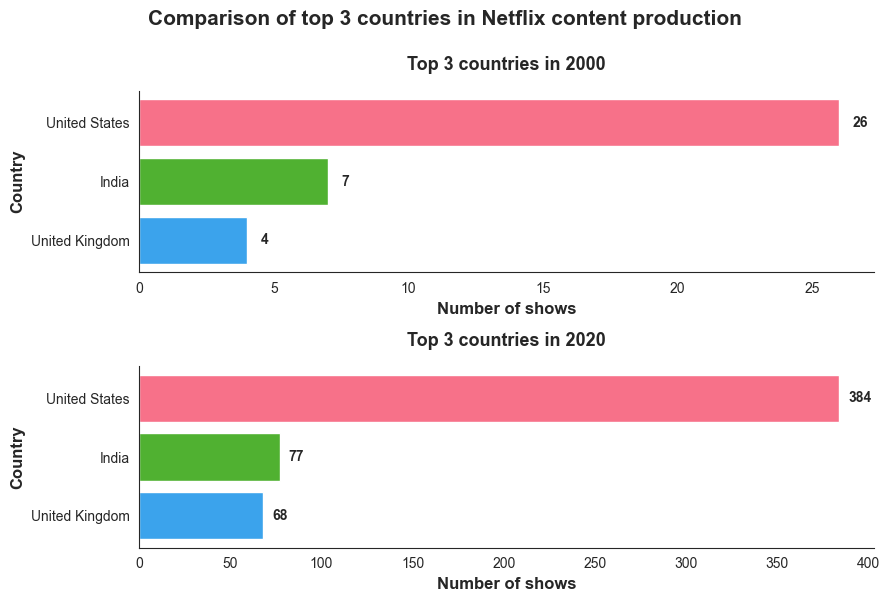

In [52]:
data_2000 = result[result['release_year'] == 2000]
data_2020 = result[result['release_year'] == 2020]

sns.set_style("white")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 6))

# Chart for 2000
colors_2000 = sns.color_palette("husl", len(data_2000))
bars1 = ax1.barh(data_2000['country'], data_2000['total_shows'], color=colors_2000)
for i, (bar, value) in enumerate(zip(bars1, data_2000['total_shows'])):
    ax1.text(value + 0.5, i, f'{value}', va='center', fontsize=10, fontweight='bold')
ax1.set_xlabel('Number of shows', fontsize=12, fontweight='bold')
ax1.set_ylabel('Country', fontsize=12, fontweight='bold')
ax1.set_title('Top 3 countries in 2000', fontsize=13, fontweight='bold', pad=15)
ax1.invert_yaxis()
sns.despine(ax=ax1)

# Chart for 2020
colors_2020 = sns.color_palette("husl", len(data_2020))
bars2 = ax2.barh(data_2020['country'], data_2020['total_shows'], color=colors_2020)
for i, (bar, value) in enumerate(zip(bars2, data_2020['total_shows'])):
    ax2.text(value + 5, i, f'{value}', va='center', fontsize=10, fontweight='bold')
ax2.set_xlabel('Number of shows', fontsize=12, fontweight='bold')
ax2.set_ylabel('Country', fontsize=12, fontweight='bold')
ax2.set_title('Top 3 countries in 2020', fontsize=13, fontweight='bold', pad=15)
ax2.invert_yaxis()
sns.despine(ax=ax2)

plt.suptitle('Comparison of top 3 countries in Netflix content production', 
             fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()

plt.show()

In [53]:
con.close()